Importamos librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Dataset

In [3]:
df = pd.read_csv('Data_FINAL_all.csv')
df = df.drop(columns=['Unnamed: 0','SCORE'])

In [4]:
FEATURES_CONT = ["Factibilidad", "Global_Market_norm", "Opc_futuras", "Regional Comp"]
TARGET = "y_t3"
TIME_COL = "year"
COUNTRY_COL = "country"

FOLDS del Rolling Origin

In [5]:
folds = [
    {"train_years": list(range(1999, 2007)), "val_years": [2007, 2008]},
    {"train_years": list(range(1999, 2009)), "val_years": [2009, 2010]},
    {"train_years": list(range(1999, 2011)), "val_years": [2011, 2012]},
    {"train_years": list(range(1999, 2013)), "val_years": [2013, 2014]},
    {"train_years": list(range(1999, 2015)), "val_years": [2015, 2016]},
]

TEST_YEARS = [2017, 2018]

In [6]:
def split_by_years(df, train_years, val_years):
    train_mask = df[TIME_COL].isin(train_years)
    val_mask = df[TIME_COL].isin(val_years)

    df_train = df[train_mask].copy()
    df_val = df[val_mask].copy()

    X_train = df_train[FEATURES_CONT]
    y_train = df_train[TARGET].values

    X_val = df_val[FEATURES_CONT]
    y_val = df_val[TARGET].values

    return X_train, y_train, X_val, y_val, df_val

Metrica Recall

In [ ]:
def recall_at_k_macro(df_val, y_scores, k=10,
                      group_cols=(COUNTRY_COL, TIME_COL),
                      target_col=TARGET):

    assert len(df_val) == len(y_scores), "df_val y y_scores deben tener la misma longitud"

    tmp = df_val[[*group_cols, target_col]].copy()
    tmp["score"] = y_scores

    recalls = []

    for _, group in tmp.groupby(list(group_cols)):
        
        group_sorted = group.sort_values("score", ascending=False)

        
        top_k = group_sorted.head(k)

        y_true = group_sorted[target_col].values
        y_true_top = top_k[target_col].values

        n_pos = (y_true == 1).sum()
        if n_pos == 0:
            # Sin positivos en este país-año: no aporta información al recall
            continue

        tp = (y_true_top == 1).sum()
        recall_g = tp / n_pos
        recalls.append(recall_g)

    if len(recalls) == 0:
        return np.nan

    return float(np.mean(recalls))


In [ ]:
def generate_simplex_grid(step=0.05, dim=4):
   
    assert dim == 4

    values = np.arange(0, 1 + step/2, step)
    weights = []

    for w1 in values:
        for w2 in values:
            for w3 in values:
                w4 = 1.0 - (w1 + w2 + w3)
                if w4 < -1e-8:
                    continue
                if w4 < 0:
                    w4 = 0.0
                s = w1 + w2 + w3 + w4
                if abs(s - 1.0) <= 1e-8:
                    weights.append([w1, w2, w3, w4])

    return np.array(weights)


def generate_dirichlet_weights(n_samples=2048, dim=4, alpha=1.0, random_state=42):

    rng = np.random.default_rng(random_state)
    alpha_vec = np.full(dim, alpha, dtype=float)
    weights = rng.dirichlet(alpha_vec, size=n_samples)
    return weights



In [ ]:

DIM = len(FEATURES_CONT)

#Grilla
grid_weights = generate_simplex_grid(step=0.05, dim=DIM)
print("Pesos de grilla:", grid_weights.shape)

#Muestras Dirichlet
dirichlet_weights = generate_dirichlet_weights(
    n_samples=2048,
    dim=DIM,
    alpha=1.0,
    random_state=123
)
print("Pesos Dirichlet:", dirichlet_weights.shape)

all_candidates = np.vstack([grid_weights, dirichlet_weights])




Pesos de grilla: (1771, 4)
Pesos Dirichlet: (2048, 4)


In [ ]:
def evaluate_weight_on_fold(df, weight, fold, k=10):
    
    _, _, X_val, y_val, df_val = split_by_years(
        df,
        train_years=fold["train_years"],
        val_years=fold["val_years"]
    )

    # Score lineal: w' x
    scores_val = X_val @ weight

    # Métrica objetivo
    rec = recall_at_k_macro(df_val, scores_val, k=k)
    return rec


def evaluate_candidates_cv(df, cand, folds, k=10):
   
    records = []

    for cid, w in enumerate(cand):
        fold_scores = []
        for fold in folds:
            rec = evaluate_weight_on_fold(df, w, fold, k=k)
            fold_scores.append(rec)

        mean_rec = np.nanmean(fold_scores)

        record = {
            "candidate_id": cid,
            "mean_recall_cv": mean_rec
        }

        
        for feat, wi in zip(FEATURES_CONT, w):
            record[f"w_{feat}"] = wi

        
        for i, rec in enumerate(fold_scores):
            record[f"recall_fold_{i+1}"] = rec

        records.append(record)

    results_df = pd.DataFrame(records).sort_values(
        "mean_recall_cv", ascending=False
    ).reset_index(drop=True)

    return results_df


In [ ]:
K_TOP = 10 

cv_results = evaluate_candidates_cv(
    df=df,
    cand=all_candidates,
    folds=folds,
    k=K_TOP
)

cv_results.head(10)


,candidate_id,mean_recall_cv,w_Factibilidad,w_Global_Market_norm,w_Opc_futuras,w_Regional Comp,recall_fold_1,recall_fold_2,recall_fold_3,recall_fold_4,recall_fold_5
0,1369,0.154686,0.400000,0.200000,0.350000,0.050000,0.154624,0.156483,0.153253,0.161453,0.147616
1,3569,0.154606,0.324010,0.215433,0.192713,0.267844,0.147676,0.152463,0.160969,0.162375,0.149548
2,1882,0.154584,0.330666,0.203954,0.209756,0.255623,0.145304,0.156591,0.162581,0.162556,0.145887
3,1265,0.154515,0.350000,0.200000,0.200000,0.250000,0.144143,0.158173,0.161878,0.162092,0.146289
4,1267,0.154428,0.350000,0.200000,0.300000,0.150000,0.153160,0.152285,0.156587,0.161148,0.148962
5,1255,0.154396,0.350000,0.150000,0.250000,0.250000,0.145814,0.156515,0.158168,0.162145,0.149337
6,1256,0.154300,0.350000,0.150000,0.300000,0.200000,0.152292,0.153586,0.162040,0.160286,0.143293
7,3162,0.154155,0.292280,0.260231,0.273914,0.173575,0.154032,0.148598,0.160485,0.162049,0.145609
8,1137,0.153996,0.300000,0.150000,0.200000,0.350000,0.146329,0.152037,0.158080,0.162407,0.151125
9,1368,0.153949,0.400000,0.200000,0.300000,0.100000,0.152523,0.156483,0.156202,0.161219,0.143319


Text(0, 0.5, 'promedio Recall@10')

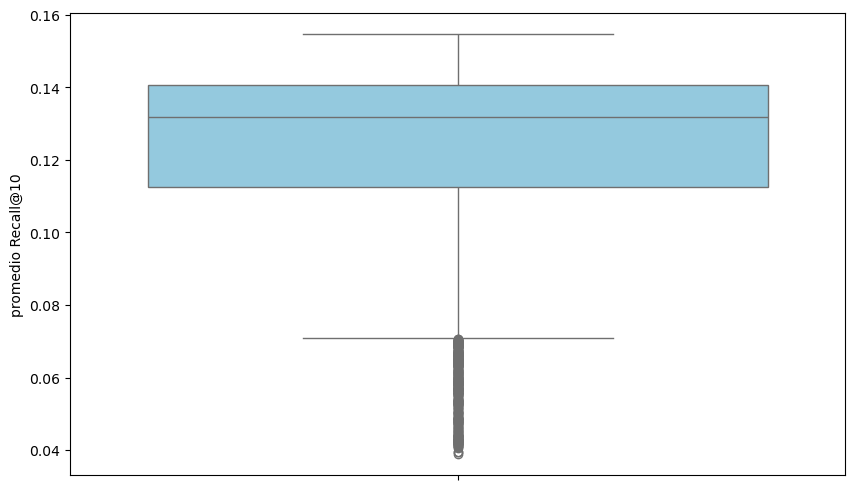

In [ ]:
#boxplot distribucion proemdio
plt.figure(figsize=(10, 6))
sns.boxplot(y=cv_results["mean_recall_cv"], color="skyblue")
plt.ylabel("promedio Recall@10")

In [16]:
top20 = cv_results.head(20)[['w_Factibilidad', 'w_Global_Market_norm', 'w_Opc_futuras', 'w_Regional Comp']]

In [17]:
top20

,w_Factibilidad,w_Global_Market_norm,w_Opc_futuras,w_Regional Comp
0,0.400000,0.200000,0.350000,0.050000
1,0.324010,0.215433,0.192713,0.267844
2,0.330666,0.203954,0.209756,0.255623
3,0.350000,0.200000,0.200000,0.250000
4,0.350000,0.200000,0.300000,0.150000
5,0.350000,0.150000,0.250000,0.250000
6,0.350000,0.150000,0.300000,0.200000
7,0.292280,0.260231,0.273914,0.173575
8,0.300000,0.150000,0.200000,0.350000
9,0.400000,0.200000,0.300000,0.100000


In [18]:
cv_results

,candidate_id,mean_recall_cv,w_Factibilidad,w_Global_Market_norm,w_Opc_futuras,w_Regional Comp,recall_fold_1,recall_fold_2,recall_fold_3,recall_fold_4,recall_fold_5
0,1369,0.154686,0.400000,0.200000,0.350000,0.050000,0.154624,0.156483,0.153253,0.161453,0.147616
1,3569,0.154606,0.324010,0.215433,0.192713,0.267844,0.147676,0.152463,0.160969,0.162375,0.149548
2,1882,0.154584,0.330666,0.203954,0.209756,0.255623,0.145304,0.156591,0.162581,0.162556,0.145887
3,1265,0.154515,0.350000,0.200000,0.200000,0.250000,0.144143,0.158173,0.161878,0.162092,0.146289
4,1267,0.154428,0.350000,0.200000,0.300000,0.150000,0.153160,0.152285,0.156587,0.161148,0.148962
...,...,...,...,...,...,...,...,...,...,...,...
3814,2667,0.040918,0.005751,0.035962,0.917110,0.041177,0.056845,0.044845,0.028166,0.040105,0.034628
3815,17,0.040675,0.000000,0.000000,0.850000,0.150000,0.056855,0.047417,0.026729,0.039795,0.032578
3816,20,0.039463,0.000000,0.000000,1.000000,0.000000,0.052843,0.045228,0.027436,0.039772,0.032035
3817,18,0.039387,0.000000,0.000000,0.900000,0.100000,0.053990,0.045841,0.026677,0.038617,0.031812


In [20]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

FEATURES_CONT = ["Factibilidad", "Global_Market_norm", "Opc_futuras", "Regional Comp"]
TARGET = "y_t3"
TIME_COL = "year"
COUNTRY_COL = "country"


def recall_at_k_macro(df, scores, k=10):
    """
    Recall@k macro por grupo (country, year).
    Se promedia sólo sobre grupos que tienen al menos un positivo.
    Ajusta si tu definición original difiere.
    """
    df_tmp = df.copy()
    df_tmp["score"] = scores

    recalls = []
    for (_, _), g in df_tmp.sort_values("score", ascending=False)\
                           .groupby([COUNTRY_COL, TIME_COL]):
        y = g[TARGET].values
        pos_total = y.sum()
        if pos_total == 0:
            continue  # este grupo no aporta al recall macro
        topk = y[:k]
        recalls.append(topk.sum() / pos_total)

    if len(recalls) == 0:
        return 0.0
    return float(np.mean(recalls))


def compute_scores(df, weights):
    """
    df: DataFrame con columnas FEATURES_CONT
    weights: array-like de longitud len(FEATURES_CONT)
    """
    X = df[FEATURES_CONT].values
    w = np.asarray(weights)
    return X @ w


In [21]:
def softmax(alpha):
    alpha = np.asarray(alpha, dtype=float)
    alpha = alpha - np.max(alpha)  # para estabilidad numérica
    exp_a = np.exp(alpha)
    return exp_a / exp_a.sum()


def weights_to_alpha(w, eps=1e-8):
    """
    Inversa aproximada de softmax para inicializar alpha a partir de w.
    """
    w = np.asarray(w, dtype=float)
    w = np.clip(w, eps, 1.0)
    return np.log(w)


def optimize_weights_on_train(df_train, initial_weights, k=10, maxiter=200):
    """
    Optimiza pesos usando SOLO df_train como función objetivo (recall@k_macro).
    Devuelve (w_opt, best_recall_train)
    """
    alpha0 = weights_to_alpha(initial_weights)

    def objective(alpha):
        w = softmax(alpha)
        scores_train = compute_scores(df_train, w)
        # Queremos MAXIMIZAR el recall, así que minimizamos el negativo
        return -recall_at_k_macro(df_train, scores_train, k=k)

    res = minimize(
        objective,
        alpha0,
        method="Nelder-Mead",
        options={"maxiter": maxiter, "xatol": 1e-3, "fatol": 1e-4, "disp": False},
    )

    alpha_opt = res.x
    w_opt = softmax(alpha_opt)
    best_recall_train = -res.fun

    return w_opt, best_recall_train


In [30]:
top_weights = top20[['w_Factibilidad',
                     'w_Global_Market_norm',
                     'w_Opc_futuras',
                     'w_Regional Comp']].to_numpy()

In [31]:
top_weights

array([[0.4       , 0.2       , 0.35      , 0.05      ],
       [0.32400988, 0.2154333 , 0.19271302, 0.2678438 ],
       [0.33066636, 0.20395406, 0.20975618, 0.2556234 ],
       [0.35      , 0.2       , 0.2       , 0.25      ],
       [0.35      , 0.2       , 0.3       , 0.15      ],
       [0.35      , 0.15      , 0.25      , 0.25      ],
       [0.35      , 0.15      , 0.3       , 0.2       ],
       [0.29227974, 0.26023113, 0.27391407, 0.17357507],
       [0.3       , 0.15      , 0.2       , 0.35      ],
       [0.4       , 0.2       , 0.3       , 0.1       ],
       [0.42554012, 0.18258182, 0.35052266, 0.0413554 ],
       [0.37456063, 0.19341124, 0.27440963, 0.15761849],
       [0.3       , 0.25      , 0.2       , 0.25      ],
       [0.34313889, 0.12975555, 0.30645771, 0.22064785],
       [0.27898642, 0.13822994, 0.27017122, 0.31261242],
       [0.35      , 0.2       , 0.35      , 0.1       ],
       [0.3       , 0.2       , 0.3       , 0.2       ],
       [0.35959042, 0.19928549,

# 2. Proceso de busqueda local con Nelder-Mead

In [32]:
cv_results_local = []

for idx, w0 in enumerate(top_weights):
    fold_val_recalls = []
    fold_details = []

    for f_id, fold in enumerate(folds):
        train_years = fold["train_years"]
        val_years = fold["val_years"]

        df_train = df[df[TIME_COL].isin(train_years)].copy()
        df_val = df[df[TIME_COL].isin(val_years)].copy()

        # 1) Optimización local SOLO en TRAIN del fold
        w_opt, train_recall = optimize_weights_on_train(
            df_train,
            initial_weights=w0,
            k=K_TOP,
            maxiter=200
        )

        # 2) Evaluación en VALIDACIÓN del fold
        scores_val = compute_scores(df_val, w_opt)
        val_recall = recall_at_k_macro(df_val, scores_val, k=K_TOP)

        fold_val_recalls.append(val_recall)
        fold_details.append({
            "fold_id": f_id,
            "train_years": train_years,
            "val_years": val_years,
            "w_opt": w_opt,
            "train_recall": train_recall,
            "val_recall": val_recall,
        })

    mean_val_recall = float(np.mean(fold_val_recalls))

    cv_results_local.append({
        "candidate_id": idx,
        "w0": w0,
        "mean_val_recall": mean_val_recall,
        "fold_details": fold_details,
    })

cv_results_local_sorted = sorted(cv_results_local,
                                 key=lambda d: d["mean_val_recall"],
                                 reverse=True)

best_candidate = cv_results_local_sorted[0]
best_candidate_id = best_candidate["candidate_id"]
best_w0 = best_candidate["w0"]
best_cv_score = best_candidate["mean_val_recall"]

print("Mejor candidato inicial (fila de top20):", best_candidate_id)
print("Pesos iniciales:", best_w0)
print("Recall@{} medio en folds (validación): {:.4f}".format(K_TOP, best_cv_score))

Mejor candidato inicial (fila de top20): 1
Pesos iniciales: [0.32400988 0.2154333  0.19271302 0.2678438 ]
Recall@10 medio en folds (validación): 0.1548


## 2.1 cv resultados en lista

In [33]:
cv_results_local_sorted

[{'candidate_id': 1,
  'w0': array([0.32400988, 0.2154333 , 0.19271302, 0.2678438 ]),
  'mean_val_recall': 0.15482011920713581,
  'fold_details': [{'fold_id': 0,
    'train_years': [1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006],
    'val_years': [2007, 2008],
    'w_opt': array([0.33245366, 0.21842156, 0.20493453, 0.24419025]),
    'train_recall': 0.14794207853026436,
    'val_recall': 0.14879424891269072},
   {'fold_id': 1,
    'train_years': [1999,
     2000,
     2001,
     2002,
     2003,
     2004,
     2005,
     2006,
     2007,
     2008],
    'val_years': [2009, 2010],
    'w_opt': array([0.32564759, 0.21007699, 0.21065094, 0.25362448]),
    'train_recall': 0.1477776233494798,
    'val_recall': 0.15593134247838192},
   {'fold_id': 2,
    'train_years': [1999,
     2000,
     2001,
     2002,
     2003,
     2004,
     2005,
     2006,
     2007,
     2008,
     2009,
     2010],
    'val_years': [2011, 2012],
    'w_opt': array([0.3453255 , 0.17448344, 0.23279949, 0.2473915

# 3. Optimización final del peso encontrado.

In [25]:
GROUP_COLS = ["country", "year"]

# Definimos los splits de años
train_years = list(range(1999, 2015))   # 1999-2014
val_years   = [2015, 2016]
hold_years  = [2017, 2018]

df_train = df[df["year"].isin(train_years)].copy()
df_val   = df[df["year"].isin(val_years)].copy()
df_hold  = df[df["year"].isin(hold_years)].copy()

## 3.1 Funciones

In [ ]:

def recall_at_k_macro(df_subset, target_col, score_col, k=10):
    
    recalls = []

    for (c, t), g in df_subset.groupby(GROUP_COLS):
        
        g_sorted = g.sort_values(score_col, ascending=False)


        g_topk = g_sorted.head(k)


        true_positives_total = g[target_col].sum()

        if true_positives_total == 0:
            continue

        true_positives_topk = g_topk[target_col].sum()

        recall_k = true_positives_topk / true_positives_total
        recalls.append(recall_k)

    if len(recalls) == 0:
        return 0.0

    return float(np.mean(recalls))


In [ ]:

def softmax(theta):
    
    theta = np.asarray(theta, dtype=float)
    exps = np.exp(theta - np.max(theta))

    return exps / exps.sum()

def evaluate_weights(df_subset, weights, k=10):

    w = np.asarray(weights, dtype=float)
   
    w = np.clip(w, 0, None)
    if w.sum() == 0:
        return 0.0
    w = w / w.sum()

    df_scored = df_subset.copy()
    X = df_scored[FEATURES_CONT].values
    df_scored["score"] = X @ w

    return recall_at_k_macro(df_scored, TARGET, "score", k=10)

def objective(theta, df_train, k=10):
    
    w = softmax(theta)
    r = evaluate_weights(df_train, w, k=k)
    return -r  # maximizar recall@k ≡ minimizar -recall@k


## 3.3 Peso final

In [ ]:

w0 = np.array([0.32400988, 0.2154333, 0.19271302, 0.2678438], dtype=float)

theta0 = np.log(w0)

res = minimize(
    fun=objective,
    x0=theta0,
    args=(df_train, 10),   
    method="Nelder-Mead",
    options={
        "maxiter": 2000,
        "fatol": 1e-4,
        "xatol": 1e-4,
        "adaptive": True,
        "disp": True,
    }
)

res


Optimization terminated successfully.
         Current function value: -0.152936
         Iterations: 55
         Function evaluations: 185


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -0.1529358449126589
             x: [-1.107e+00 -1.624e+00 -1.567e+00 -1.356e+00]
           nit: 55
          nfev: 185
 final_simplex: (array([[-1.107e+00, -1.624e+00, -1.567e+00, -1.356e+00],
                       [-1.107e+00, -1.623e+00, -1.567e+00, -1.356e+00],
                       ...,
                       [-1.107e+00, -1.623e+00, -1.567e+00, -1.356e+00],
                       [-1.107e+00, -1.623e+00, -1.567e+00, -1.356e+00]]), array([-1.529e-01, -1.529e-01, -1.529e-01, -1.529e-01,
                       -1.529e-01]))

In [31]:

w_opt = softmax(res.x)

print("Pesos iniciales: ", w0)
print("Pesos optimizados:", w_opt, " (suma =", w_opt.sum(), ")")

recall_train = evaluate_weights(df_train, w_opt, k=10)
recall_val   = evaluate_weights(df_val,   w_opt, k=10)
recall_hold  = evaluate_weights(df_hold,  w_opt, k=10)

print(f"Recall@10 entrenamiento (1999-2014):  {recall_train:.4f}")
print(f"Recall@10 validación (2015-2016):  {recall_val:.4f}")
print(f"Recall@10 holdout  (2017-2018):  {recall_hold:.4f}")


Pesos iniciales:  [0.32400988 0.2154333  0.19271302 0.2678438 ]
Pesos optimizados: [0.33243646 0.1983811  0.20984264 0.25933979]  (suma = 0.9999999999999998 )
Recall@10 TRAIN (1999-2014):  0.1529
Recall@10 VALID (2015-2016):  0.1459
Recall@10 HOLD  (2017-2018):  0.1682


# 4. Análisis sensibilidad

In [ ]:
w_opt = np.array([0.33243646, 0.1983811,  0.20984264, 0.25933979])

print("Pesos iniciales: ", w0)
print("Pesos optimizados:", w_opt, " (suma =", w_opt.sum(), ")")

# Recall en train, val y holdout
recall_train = evaluate_weights(df_train, w_opt, k=10)
recall_val   = evaluate_weights(df_val,   w_opt, k=10)
recall_hold  = evaluate_weights(df_hold,  w_opt, k=10)

print(f"Recall@10 TRAIN (1999-2014):  {recall_train:.4f}")
print(f"Recall@10 VALID (2015-2016):  {recall_val:.4f}")
print(f"Recall@10 HOLD  (2017-2018):  {recall_hold:.4f}")

Pesos iniciales:  [0.32400988 0.2154333  0.19271302 0.2678438 ]
Pesos optimizados: [0.2 0.3 0.2 0.3]  (suma = 1.0 )
Recall@10 TRAIN (1999-2014):  0.1459
Recall@10 VALID (2015-2016):  0.1498
Recall@10 HOLD  (2017-2018):  0.1512


In [ ]:
import numpy as np
import pandas as pd


sensitivities = [0.01, 0.03, 0.05, 0.10]

# Recall base con w_opt
baseline_val  = evaluate_weights(df_val,  w_opt, k=10)
baseline_hold = evaluate_weights(df_hold, w_opt, k=10)

print(f"Baseline recall@10 VALID (2015-2016):  {baseline_val:.4f}")
print(f"Baseline recall@10 HOLD  (2017-2018):  {baseline_hold:.4f}")


rows_val = []
rows_hold = []

for j, metric_name in enumerate(FEATURES_CONT):
    for pct in sensitivities:
        for direction in ["-", "+"]:
            factor = 1 - pct if direction == "-" else 1 + pct

            
            w_new = w_opt.copy()
            w_new[j] = w_new[j] * factor

            # asegurar no negatividad y renormalizar
            w_new = np.clip(w_new, 0, None)
            if w_new.sum() == 0:
                
                continue
            w_new = w_new / w_new.sum()

            
            rec_val  = evaluate_weights(df_val,  w_new, k=10)
            rec_hold = evaluate_weights(df_hold, w_new, k=10)

           
            rows_val.append({
                "metric": metric_name,
                "direction": direction,      
                "delta_pct": pct,           
                "w_Factibilidad":      w_new[0],
                "w_Global_Market":     w_new[1],
                "w_Opc_futuras":       w_new[2],
                "w_Regional_Comp":     w_new[3],
                "recall_val":          rec_val,
                "delta_recall_val":    rec_val - baseline_val,
            })

            rows_hold.append({
                "metric": metric_name,
                "direction": direction,
                "delta_pct": pct,
                "w_Factibilidad":      w_new[0],
                "w_Global_Market":     w_new[1],
                "w_Opc_futuras":       w_new[2],
                "w_Regional_Comp":     w_new[3],
                "recall_hold":         rec_hold,
                "delta_recall_hold":   rec_hold - baseline_hold,
            })


df_sens_val  = pd.DataFrame(rows_val)
df_sens_hold = pd.DataFrame(rows_hold)

print("\nSensibilidad (VALID):")
display(df_sens_val.sort_values(["metric", "delta_pct", "direction"]).head())

print("\nSensibilidad (HOLDOUT):")
display(df_sens_hold.sort_values(["metric", "delta_pct", "direction"]).head())


Baseline recall@10 VALID (2015-2016):  0.1459
Baseline recall@10 HOLD  (2017-2018):  0.1682

Sensibilidad (VALID):


,metric,direction,delta_pct,w_Factibilidad,w_Global_Market,w_Opc_futuras,w_Regional_Comp,recall_val,delta_recall_val
1,Factibilidad,+,0.01,0.334648,0.197724,0.209147,0.258481,0.145562,-0.000321
0,Factibilidad,-,0.01,0.330210,0.199043,0.210543,0.260205,0.145883,0.000000
3,Factibilidad,+,0.03,0.339028,0.196422,0.207771,0.256779,0.145204,-0.000679
2,Factibilidad,-,0.03,0.325712,0.200380,0.211957,0.261952,0.145488,-0.000395
5,Factibilidad,+,0.05,0.343351,0.195138,0.206412,0.255100,0.144770,-0.001113



Sensibilidad (HOLDOUT):


,metric,direction,delta_pct,w_Factibilidad,w_Global_Market,w_Opc_futuras,w_Regional_Comp,recall_hold,delta_recall_hold
1,Factibilidad,+,0.01,0.334648,0.197724,0.209147,0.258481,0.167862,-0.000302
0,Factibilidad,-,0.01,0.330210,0.199043,0.210543,0.260205,0.168164,0.000000
3,Factibilidad,+,0.03,0.339028,0.196422,0.207771,0.256779,0.168167,0.000003
2,Factibilidad,-,0.03,0.325712,0.200380,0.211957,0.261952,0.168639,0.000475
5,Factibilidad,+,0.05,0.343351,0.195138,0.206412,0.255100,0.168902,0.000738


In [47]:
print("\nSensibilidad (VALID):")
display(df_sens_val.sort_values(["metric", "delta_pct", "direction"]))

print("\nSensibilidad (HOLDOUT):")
display(df_sens_hold.sort_values(["metric", "delta_pct", "direction"]))


Sensibilidad (VALID):


,metric,direction,delta_pct,w_Factibilidad,w_Global_Market,w_Opc_futuras,w_Regional_Comp,recall_val,delta_recall_val
1,Factibilidad,+,0.01,0.334648,0.197724,0.209147,0.258481,0.145562,-0.000321
0,Factibilidad,-,0.01,0.330210,0.199043,0.210543,0.260205,0.145883,0.000000
3,Factibilidad,+,0.03,0.339028,0.196422,0.207771,0.256779,0.145204,-0.000679
2,Factibilidad,-,0.03,0.325712,0.200380,0.211957,0.261952,0.145488,-0.000395
5,Factibilidad,+,0.05,0.343351,0.195138,0.206412,0.255100,0.144770,-0.001113
4,Factibilidad,-,0.05,0.321153,0.201734,0.213390,0.263723,0.145504,-0.000379
7,Factibilidad,+,0.10,0.353915,0.191998,0.203091,0.250996,0.146845,0.000962
6,Factibilidad,-,0.10,0.309481,0.205203,0.217058,0.268258,0.144131,-0.001752
9,Global_Market_norm,+,0.01,0.331778,0.199968,0.209427,0.258826,0.145883,0.000000
8,Global_Market_norm,-,0.01,0.333097,0.196788,0.210260,0.259855,0.145701,-0.000182



Sensibilidad (HOLDOUT):


,metric,direction,delta_pct,w_Factibilidad,w_Global_Market,w_Opc_futuras,w_Regional_Comp,recall_hold,delta_recall_hold
1,Factibilidad,+,0.01,0.334648,0.197724,0.209147,0.258481,0.167862,-0.000302
0,Factibilidad,-,0.01,0.330210,0.199043,0.210543,0.260205,0.168164,0.000000
3,Factibilidad,+,0.03,0.339028,0.196422,0.207771,0.256779,0.168167,0.000003
2,Factibilidad,-,0.03,0.325712,0.200380,0.211957,0.261952,0.168639,0.000475
5,Factibilidad,+,0.05,0.343351,0.195138,0.206412,0.255100,0.168902,0.000738
4,Factibilidad,-,0.05,0.321153,0.201734,0.213390,0.263723,0.168496,0.000332
7,Factibilidad,+,0.10,0.353915,0.191998,0.203091,0.250996,0.167448,-0.000716
6,Factibilidad,-,0.10,0.309481,0.205203,0.217058,0.268258,0.167612,-0.000552
9,Global_Market_norm,+,0.01,0.331778,0.199968,0.209427,0.258826,0.168164,0.000000
8,Global_Market_norm,-,0.01,0.333097,0.196788,0.210260,0.259855,0.168038,-0.000126


In [ ]:
#

Baseline VALID  recall@10: 0.1459
Baseline HOLD   recall@10: 0.1682


(         metric  index direction  pct_change  recall_val  delta_recall_val  \
 0  Factibilidad      0        up        0.01    0.145562         -0.000321   
 1  Factibilidad      0      down        0.01    0.145883          0.000000   
 2  Factibilidad      0        up        0.03    0.145204         -0.000679   
 3  Factibilidad      0      down        0.03    0.145488         -0.000395   
 4  Factibilidad      0        up        0.05    0.144770         -0.001113   
 
    w0_Factibilidad  w0_Global_Market  w0_Opc_futuras  w0_Regional_Comp  \
 0         0.332436          0.198381        0.209843           0.25934   
 1         0.332436          0.198381        0.209843           0.25934   
 2         0.332436          0.198381        0.209843           0.25934   
 3         0.332436          0.198381        0.209843           0.25934   
 4         0.332436          0.198381        0.209843           0.25934   
 
    w_Factibilidad  w_Global_Market  w_Opc_futuras  w_Regional_Comp  
 0

In [ ]:
import numpy as np
import pandas as pd



# Promedio de variación por
summary = (
    df_sens_val
    .groupby(["delta_pct", "metric", "direction"], as_index=False)["delta_recall_val"]
    .mean()
)

# Pivot intermedio
pivot_dir = (
    summary
    .pivot(index=["delta_pct", "metric"], columns="direction", values="delta_recall_val")
    .reset_index()
)

# Por si algún caso no tuvo "+" o "-" rellenamos con 0
pivot_dir[["+", "-"]] = pivot_dir[["+", "-"]].fillna(0.0)

# Convertimos las variaciones a porcentaje (puntos porcentuales)
pivot_dir["minus_pp"] = pivot_dir["-"] * 100  # bajar peso
pivot_dir["plus_pp"]  = pivot_dir["+"] * 100  # subir peso


pivot_dir["delta_recall_pm"] = (
    pivot_dir["minus_pp"].round(2).astype(str) + "% / " +
    pivot_dir["plus_pp"].round(2).astype(str)  + "%"
)

# Tabla final
table_sens_val = pivot_dir.pivot(
    index="delta_pct",
    columns="metric",
    values="delta_recall_pm"
)

# index como %
table_sens_val.index = (table_sens_val.index * 100).astype(int).astype(str) + "%"

print("Tabla de sensibilidad VALID (celdas = cambio en recall: bajar / subir peso, en puntos porcentuales):")
display(table_sens_val)


Tabla de sensibilidad VALID (celdas = cambio en recall: bajar / subir peso, en puntos porcentuales):


metric,Factibilidad,Global_Market_norm,Opc_futuras,Regional Comp
delta_pct,,,,
1%,0.0% / -0.03%,-0.02% / 0.0%,0.02% / 0.0%,-0.06% / 0.03%
3%,-0.04% / -0.07%,0.0% / 0.02%,0.07% / -0.04%,-0.1% / 0.03%
5%,-0.04% / -0.11%,0.0% / 0.07%,0.03% / -0.11%,-0.01% / -0.07%
10%,-0.18% / 0.1%,-0.0% / 0.07%,0.24% / -0.04%,-0.06% / -0.07%


In [ ]:


summary_hold = (
    df_sens_hold
    .groupby(["delta_pct", "metric", "direction"], as_index=False)["delta_recall_hold"]
    .mean()
)

pivot_dir_hold = (
    summary_hold
    .pivot(index=["delta_pct", "metric"], columns="direction", values="delta_recall_hold")
    .reset_index()
)

pivot_dir_hold[["+", "-"]] = pivot_dir_hold[["+", "-"]].fillna(0.0)

pivot_dir_hold["minus_pct"] = pivot_dir_hold["-"] * 100
pivot_dir_hold["plus_pct"]  = pivot_dir_hold["+"] * 100

pivot_dir_hold["delta_recall_pm"] = (
    pivot_dir_hold["minus_pct"].round(2).astype(str) + " % / " +
    pivot_dir_hold["plus_pct"].round(2).astype(str)  + " %"
)

table_sens_hold = pivot_dir_hold.pivot(
    index="delta_pct",
    columns="metric",
    values="delta_recall_pm"
)

table_sens_hold.index = (table_sens_hold.index * 100).astype(int).astype(str) + "%"

print("Tabla de sensibilidad HOLDOUT (celdas = cambio en recall: bajar / subir peso, en %):")
display(table_sens_hold)


Tabla de sensibilidad HOLDOUT (celdas = cambio en recall: bajar / subir peso, en %):


metric,Factibilidad,Global_Market_norm,Opc_futuras,Regional Comp
delta_pct,,,,
1%,0.0 % / -0.03 %,-0.01 % / 0.0 %,0.01 % / 0.0 %,-0.02 % / -0.01 %
3%,0.05 % / 0.0 %,-0.03 % / -0.11 %,-0.0 % / 0.01 %,-0.05 % / -0.01 %
5%,0.03 % / 0.07 %,0.05 % / -0.15 %,-0.19 % / 0.04 %,-0.12 % / -0.05 %
10%,-0.06 % / -0.07 %,0.14 % / -0.57 %,-0.2 % / 0.21 %,-0.09 % / 0.04 %
